In [146]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
data=pd.read_excel(r'D:\data_storage\Projects\flight_price_ml\data.xlsx')
data.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [149]:
#---------------------------
#Cleaning
#---------------------------

In [150]:
data['Additional_Info'].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [151]:
#Additional_Info doesn't provide much information, let's drop it
data.drop(columns=['Additional_Info'],inplace=True);

In [152]:
sum=data.isnull().sum()
pd.DataFrame({'count':sum,'%':sum*100/data.shape[0]})

,count,%
Airline,0,0.000000
Date_of_Journey,0,0.000000
Source,0,0.000000
Destination,0,0.000000
Route,1,0.009361
Dep_Time,0,0.000000
Arrival_Time,0,0.000000
Duration,0,0.000000
Total_Stops,1,0.009361
Price,0,0.000000


In [153]:
#clearing rows with nulls
data.dropna(inplace=True)

In [154]:
data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Price               int64
dtype: object

In [155]:
#---------------------------
#Encoding
#---------------------------

In [156]:
#encoding some categorical variables

#source-destination
data['Source-Destination']=data[['Source','Destination']].apply('-'.join,axis=1)
source_destination=pd.get_dummies(data['Source-Destination'])
source_destination=source_destination.rename({k:'Route_'+k for k in source_destination.columns},axis=1)
data=data.join(source_destination)
#airline
airline=pd.get_dummies(data['Airline'])
airline=airline.rename({k:'Airline_'+k for k in airline.columns},axis=1)
data=data.join(airline)

data.head(2)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,...,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,3897,...,0,1,0,0,0,0,0,0,0,0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,7662,...,0,0,0,0,0,0,0,0,0,0


In [157]:
#converting to datetime
for col in ['Date_of_Journey','Dep_Time','Arrival_Time']:
  data[col]=pd.to_datetime(data[col],dayfirst=True)

#converting time to decimal hours
for col in ['Dep_Time',"Arrival_Time"]:
  data[col+'_Hour']=data[col].dt.hour+data[col].dt.minute/60

#converting date to decimal month to capture seasonal patterns
#and day of week to capture weekly pattern
doj=data['Date_of_Journey']
data['Date_of_Journey_Month']=doj.dt.month+(doj.dt.day/doj.dt.days_in_month)
data['Date_of_Journey_Day_of_Week']=data['Date_of_Journey'].dt.day_of_week

data.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,...,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Dep_Time_Hour,Arrival_Time_Hour,Date_of_Journey_Month,Date_of_Journey_Day_of_Week
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2023-02-20 22:20:00,2023-03-22 01:10:00,2h 50m,non-stop,3897,...,0,0,0,0,0,0,22.333333,1.166667,3.774194,6
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,2023-02-20 05:50:00,2023-02-20 13:15:00,7h 25m,2 stops,7662,...,0,0,0,0,0,0,5.833333,13.250000,5.032258,2


In [158]:
#parsing duration
def preprocess_duration(x):
  if 'h' not in x:
      x='0h '+x
  elif 'm' not in x:
      x=x+' 0m'
  return x

data['Duration']=data['Duration'].apply(preprocess_duration)

def str_time_parser(x):
  a=x.split(' ')
  return(int(a[0][0:-1])+int(a[1][0:-1])/60)

data['Duration_Hour']=data['Duration'].apply(lambda x: str_time_parser(x))

data[['Duration','Duration_Hour']].head(2)



,Duration,Duration_Hour
0,2h 50m,2.833333
1,7h 25m,7.416667


In [159]:
#counting number of stops
data['Stops_Count']=data['Route'].apply(lambda x: x.count('→')-1)

data[['Route','Stops_Count']].head(6)


,Route,Stops_Count
0,BLR → DEL,0
1,CCU → IXR → BBI → BLR,2
2,DEL → LKO → BOM → COK,2
3,CCU → NAG → BLR,1
4,BLR → NAG → DEL,1
5,CCU → BLR,0


In [160]:

data['Stops_Count'].value_counts()

1    5625
0    3491
2    1520
3      45
4       1
Name: Stops_Count, dtype: int64

In [161]:
#---------------------------
#Exploration
#---------------------------
data.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,...,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Dep_Time_Hour,Arrival_Time_Hour,Date_of_Journey_Month,Date_of_Journey_Day_of_Week,Duration_Hour,Stops_Count
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2023-02-20 22:20:00,2023-03-22 01:10:00,2h 50m,non-stop,3897,...,0,0,0,0,22.333333,1.166667,3.774194,6,2.833333,0
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,2023-02-20 05:50:00,2023-02-20 13:15:00,7h 25m,2 stops,7662,...,0,0,0,0,5.833333,13.250000,5.032258,2,7.416667,2
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,2023-02-20 09:25:00,2023-06-10 04:25:00,19h 0m,2 stops,13882,...,0,0,0,0,9.416667,4.416667,6.300000,6,19.000000,2


<Axes: xlabel='Airline', ylabel='Price'>

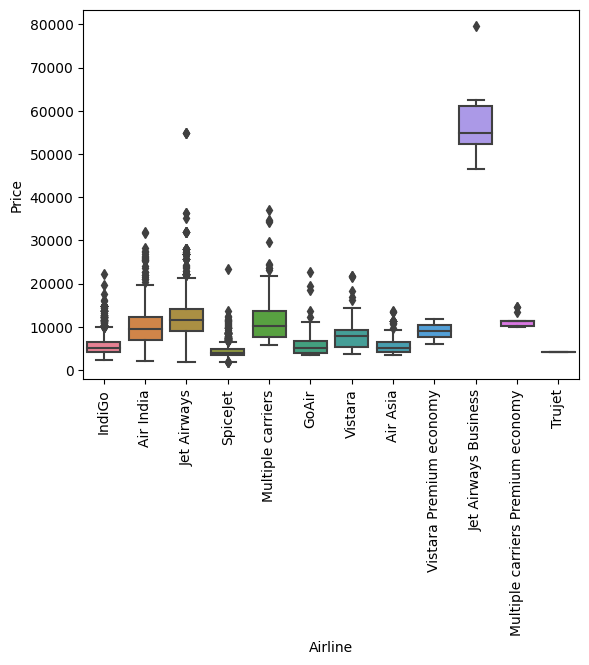

In [162]:
#A look at the effect of airline on price
plot=sns.boxplot(data=data,x='Airline',y='Price',palette="husl")
plt.setp(plot.get_xticklabels(),rotation=90)
plot


<Axes: xlabel='Source-Destination', ylabel='Price'>

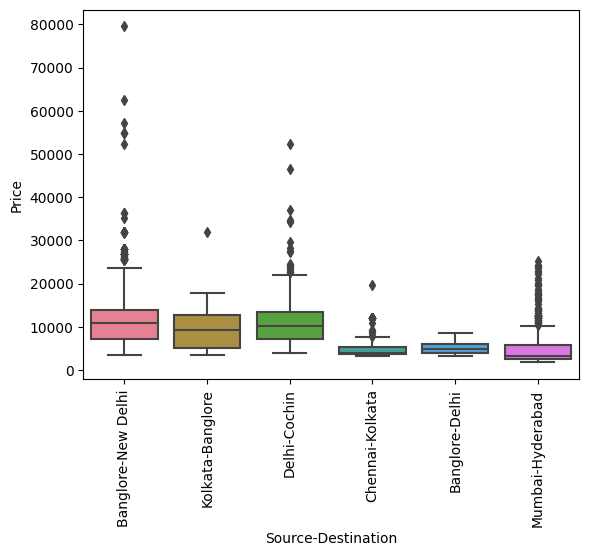

In [163]:
#A look at the effect of the route on price
plot=sns.boxplot(data=data,x='Source-Destination',y='Price',palette="husl")
plt.setp(plot.get_xticklabels(),rotation=90)
plot

<Axes: xlabel='Stops_Count', ylabel='Price'>

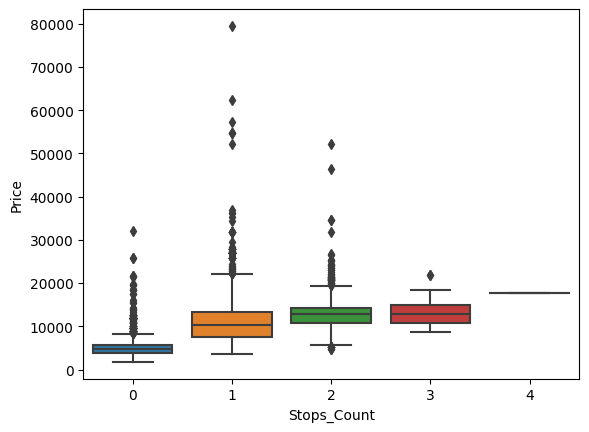

In [164]:
#Look a the effect of the number of stops on price
plot=sns.boxplot(data=data,x='Stops_Count',y='Price')
plot

<Axes: xlabel='Source-Destination', ylabel='Price'>

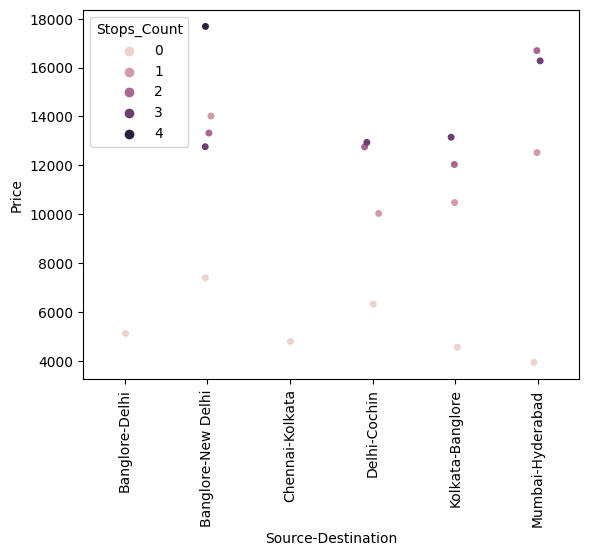

In [165]:
#Perhaps the reason the price increases with the number of stops
#is becaused it is a longer route...Let's see
group=data[['Source-Destination','Stops_Count','Price']].groupby(['Source-Destination','Stops_Count']).mean()
plot=sns.stripplot(data=group,x='Source-Destination',y='Price',hue='Stops_Count')
plt.setp(plot.get_xticklabels(),rotation=90)
plot

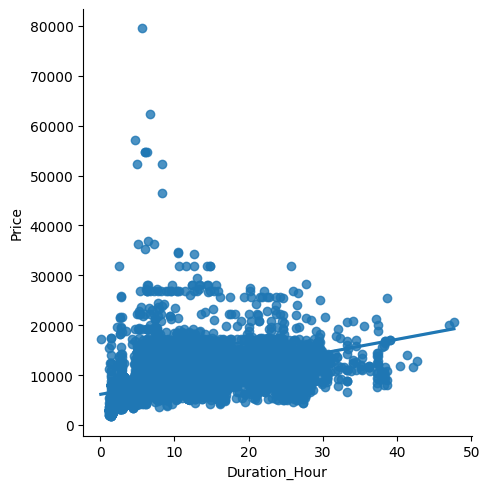

In [166]:
#It seems more stops simply = more expensive
#Let's look at the impact of flight duration
plot=sns.lmplot(data=data,x='Duration_Hour',y='Price')
plot

In [167]:
#It is probably highly collinear with number of stops
data['Stops_Count'].corr(data['Duration_Hour'])

0.7380709166001782

In [168]:
#Let's look a the impact of the departure and arrival hour
data['Dep_Time_Hour'].corr(data['Price'])

0.005467741671909098

In [169]:
data['Arrival_Time_Hour'].corr(data['Price'])


0.020901114013397105

In [170]:
#They both seem to have no effect on price, let's drop them
data.drop(columns=['Dep_Time','Arrival_Time','Dep_Time_Hour','Arrival_Time_Hour'],inplace=True);

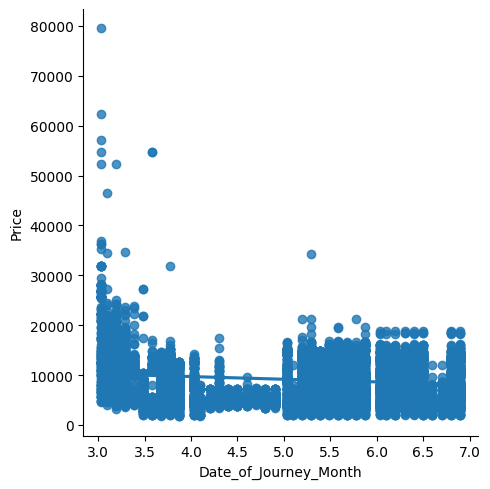

In [171]:
#Let's look at the effect of the month
sns.lmplot(data=data,x='Date_of_Journey_Month',y='Price')


In [172]:
#It looks like the month has a non-linear relationship with price
#Let's discretize, sort and take the mean
#Data only spans 4 month so lets make 52/3 bins to have one bin per week
bins=pd.cut(data['Date_of_Journey_Month'],bins=17)
bins

0        (3.715, 3.942]
1         (4.852, 5.08]
2        (6.217, 6.445]
3        (5.307, 5.535]
4         (3.028, 3.26]
              ...      
10678     (4.17, 4.397]
10679     (4.852, 5.08]
10680     (4.852, 5.08]
10681     (3.028, 3.26]
10682     (5.08, 5.307]
Name: Date_of_Journey_Month, Length: 10682, dtype: category
Categories (17, interval[float64, right]): [(3.028, 3.26] < (3.26, 3.487] < (3.487, 3.715] < (3.715, 3.942] ... (5.99, 6.217] < (6.217, 6.445] < (6.445, 6.672] < (6.672, 6.9]]

In [173]:
data['Date_Bin']=bins
data[['Date_of_Journey_Month','Date_Bin']].head(10)

,Date_of_Journey_Month,Date_Bin
0,3.774194,"(3.715, 3.942]"
1,5.032258,"(4.852, 5.08]"
2,6.300000,"(6.217, 6.445]"
3,5.387097,"(5.307, 5.535]"
4,3.032258,"(3.028, 3.26]"
5,6.800000,"(6.672, 6.9]"
6,3.387097,"(3.26, 3.487]"
7,3.032258,"(3.028, 3.26]"
8,3.387097,"(3.26, 3.487]"
9,5.870968,"(5.762, 5.99]"


In [174]:
#bin_dict={key:index for index, key in enumerate(bins,0)}
#bin_dict
date_bins=data.groupby(['Date_Bin'])['Price'].mean().sort_values()
date_bins

Date_Bin
(4.397, 4.625]     5192.456621
(4.625, 4.852]     5251.793103
(4.17, 4.397]      5726.262222
(3.942, 4.17]      6533.068120
(6.445, 6.672]     7683.581986
(4.852, 5.08]      7809.819407
(3.715, 3.942]     8107.194534
(6.672, 6.9]       8169.368098
(3.487, 3.715]     8258.065630
(5.307, 5.535]     8674.423193
(5.08, 5.307]      8886.160234
(5.762, 5.99]      8980.893713
(5.99, 6.217]      9217.500000
(6.217, 6.445]     9411.203441
(3.26, 3.487]      9806.696370
(5.535, 5.762]     9853.281718
(3.028, 3.26]     14511.296619
Name: Price, dtype: float64

In [175]:
data['Date_Bin_Mean']=data['Date_Bin'].map(date_bins).astype(float)
data[['Date_of_Journey_Month','Date_Bin','Date_Bin_Mean']].head(10)

,Date_of_Journey_Month,Date_Bin,Date_Bin_Mean
0,3.774194,"(3.715, 3.942]",8107.194534
1,5.032258,"(4.852, 5.08]",7809.819407
2,6.300000,"(6.217, 6.445]",9411.203441
3,5.387097,"(5.307, 5.535]",8674.423193
4,3.032258,"(3.028, 3.26]",14511.296619
5,6.800000,"(6.672, 6.9]",8169.368098
6,3.387097,"(3.26, 3.487]",9806.696370
7,3.032258,"(3.028, 3.26]",14511.296619
8,3.387097,"(3.26, 3.487]",9806.696370
9,5.870968,"(5.762, 5.99]",8980.893713


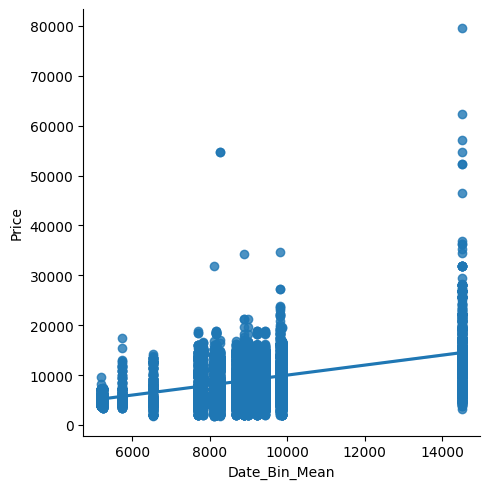

In [176]:
sns.lmplot(data=data,x='Date_Bin_Mean',y='Price')

In [177]:
data['Date_Bin_Mean'].corr(data['Price'])

0.4306009129509941

<Axes: xlabel='Date_of_Journey_Day_of_Week', ylabel='Price'>

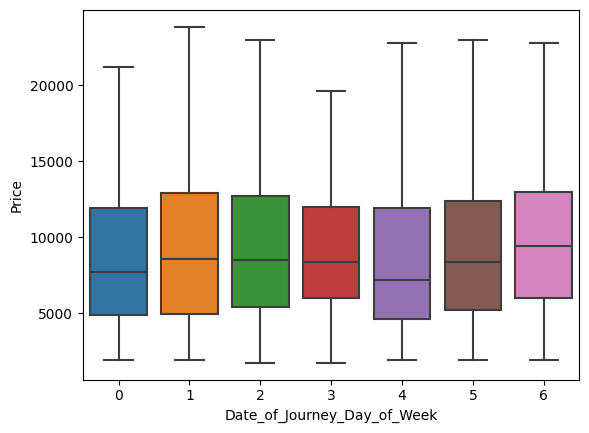

In [178]:
#Let's see the effect of the day of the week
sns.boxplot(data=data,x='Date_of_Journey_Day_of_Week',y='Price',showfliers=False)


In [179]:
#It does have an effect, let's one hot encode it
dayweek=pd.get_dummies(data['Date_of_Journey_Day_of_Week'])
dayweek=dayweek.rename({k:'Day_of_Week_'+str(k) for k in dayweek.columns},axis=1)
data=data.join(dayweek)
data.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Price,Source-Destination,Route_Banglore-Delhi,...,Stops_Count,Date_Bin,Date_Bin_Mean,Day_of_Week_0,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,3897,Banglore-New Delhi,0,...,0,"(3.715, 3.942]",8107.194534,0,0,0,0,0,0,1
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,7662,Kolkata-Banglore,0,...,2,"(4.852, 5.08]",7809.819407,0,0,1,0,0,0,0


In [180]:
data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Duration', 'Total_Stops', 'Price', 'Source-Destination',
       'Route_Banglore-Delhi', 'Route_Banglore-New Delhi',
       'Route_Chennai-Kolkata', 'Route_Delhi-Cochin', 'Route_Kolkata-Banglore',
       'Route_Mumbai-Hyderabad', 'Airline_Air Asia', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Date_of_Journey_Month', 'Date_of_Journey_Day_of_Week', 'Duration_Hour',
       'Stops_Count', 'Date_Bin', 'Date_Bin_Mean', 'Day_of_Week_0',
       'Day_of_Week_1', 'Day_of_Week_2', 'Day_of_Week_3', 'Day_of_Week_4',
       'Day_of_Week_5', 'Day_of_Week_6'],
      dtype='object')

In [182]:
train_data=data.select_dtypes([np.number])
train_data.drop(inplace=True,columns=['Date_of_Journey_Month','Date_of_Journey_Day_of_Week']);
train_data.columns


Index(['Price', 'Route_Banglore-Delhi', 'Route_Banglore-New Delhi',
       'Route_Chennai-Kolkata', 'Route_Delhi-Cochin', 'Route_Kolkata-Banglore',
       'Route_Mumbai-Hyderabad', 'Airline_Air Asia', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Duration_Hour', 'Stops_Count', 'Date_Bin_Mean', 'Day_of_Week_0',
       'Day_of_Week_1', 'Day_of_Week_2', 'Day_of_Week_3', 'Day_of_Week_4',
       'Day_of_Week_5', 'Day_of_Week_6'],
      dtype='object')

In [183]:
import sklearn as skl
from sklearn.feature_selection import mutual_info_regression

In [184]:
x=train_data.drop(['Price'],axis=1)
y=train_data['Price']
mutual_info_regression(x,y)

array([3.19747674e-01, 1.74526785e-01, 1.38249317e-01, 5.23013002e-01,
       4.52566639e-01, 2.01456509e-01, 1.15962469e-01, 2.93742894e-01,
       5.04414573e-02, 3.52573067e-01, 5.53931195e-01, 6.30256282e-03,
       2.51811173e-01, 6.12404779e-03, 1.99601347e-01, 5.12711836e-04,
       1.30668048e-01, 2.10465881e-03, 1.77156733e+00, 7.90468744e-01,
       8.04262571e-01, 6.31613770e-02, 5.14076337e-02, 8.43813522e-02,
       5.92811557e-02, 5.26130263e-02, 6.05250771e-02, 6.60300101e-02])

In [185]:
imp=pd.DataFrame(skl.feature_selection.mutual_info_regression(x,y),index=x.columns)
imp.columns=['Importance']
imp.sort_values(by='Importance',ascending=False)

,Importance
Duration_Hour,1.768324
Date_Bin_Mean,0.800673
Stops_Count,0.792068
Airline_Jet Airways,0.545780
Route_Delhi-Cochin,0.527249
Route_Kolkata-Banglore,0.461461
Airline_IndiGo,0.358664
Route_Banglore-Delhi,0.316874
Airline_Air India,0.300859
Airline_Multiple carriers,0.254969


In [97]:
#We can see that the importance of the day of the week is small
#This make sense as we saw in the box plot is about <10%


In [187]:
#Lets train/test split the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [188]:
#Let's try a random forest regressor
from sklearn.ensemble import RandomForestRegressor
ml_model=RandomForestRegressor()
model=ml_model.fit(x_train,y_train)

In [189]:
def mape(y_true,y_pred):
  ytrue,ypred=np.array(y_true),np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [190]:
mape(y_test,y_pred=model.predict(x_test))

15.582358261931425

In [191]:
#Let's look at how a basic regression would perform
from sklearn.linear_model import LinearRegression
ml_model_2=LinearRegression()
model_2=ml_model_2.fit(x_train,y_train)

In [192]:
mape(y_test,y_pred=model_2.predict(x_test))

23.505580618229878

In [193]:
#Let's try to tune the random forest regressor
from sklearn.model_selection import RandomizedSearchCV
model_to_tune=RandomForestRegressor()

search_space={
  'n_estimators':[int(x) for x in np.linspace(start=10,stop=5000,num=10)],
  'max_features':["auto","sqrt"],
  'max_depth':[int(x) for x in np.linspace(start=5,stop=30,num=5)],
  'min_samples_split':[5,10,20,40,80,160]
}

In [198]:
tuned_model=RandomizedSearchCV(model_to_tune,param_distributions=search_space,cv=3,verbose=2,n_jobs=-1)

In [199]:
tuned_model.fit(x_train,y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Python310\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [200]:
tuned_model.best_params_

{'n_estimators': 3336,
 'min_samples_split': 10,
 'max_features': 'auto',
 'max_depth': 11}

In [201]:
mape(y_test,y_pred=tuned_model.predict(x_test))

15.188763518209262